We will implement multitask model - buy and click.

Model 1:
- Input
 - 9 products displayed to users (emb, discrete attributes, continuous attributes of products)
 - User's click history (emb, discrete attributes, continuous attributes of products)
 - User attributes (discrete attributes)
- Output
 - The user purchased the first session (purchased 0-3, 4-6, 7-9, three types of sessions)
 - Whether the user bought these 9 products (you can use the 4 types of product reweighting loss mentioned by Gaochen)

Model 2:
- Input
 - User’s previous click history (commodity emb, discrete attributes, and continuous attributes become discrete)
 - The product currently clicked by the user (the emb, discrete attributes, and continuous attributes of the product become discrete)
 - User attributes (discrete attributes)
- Output
 - Whether the user clicked on this product

The above two models share all emb.

In [ ]:
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/train.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/item_info.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track1_testset.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track2_testset.parquet.snappy

train.parquet.snapp 100%[===================>]  65.26M   176MB/s    in 0.4s    
item_info.parquet.s 100%[===================>]  10.06K  --.-KB/s    in 0s      
track1_testset.parq 100%[===================>]  48.66M   165MB/s    in 0.3s    
track2_testset.parq 100%[===================>]  43.19M   143MB/s    in 0.3s    


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./

## pre

In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import einops

## 把所有的 feature 改成 离散的分桶

In [ ]:
def load_item_info(data_path='/content/'):
    # item info
    df_item_info = pd.read_parquet(f'{data_path}/item_info.parquet.snappy')
    item_info_dict = {}
    for i in tqdm(range(df_item_info.shape[0])):
        item_id = df_item_info.at[i, 'item_id'] 

        item_discrete = df_item_info.at[i, 'item_vec'].split(',')[:3]
        item_cont = df_item_info.at[i, 'item_vec'].split(',')[-2:]
        price = df_item_info.at[i, 'price'] # / 3000
        loc = df_item_info.at[i, 'location'] - 1 # 0~2

        item_cont.append(price) # 2 + 1
        item_discrete.append(loc) # 3 + 1

        item_cont = [float(it) for it in item_cont]
        item_discrete = [int(it) for it in item_discrete]
        item_discrete[0] = item_discrete[0] - 1 # 1~4 -> 0~3
        item_discrete[2] = item_discrete[2] - 1 # 1~2 -> 0~1

        item_info_dict[int(item_id)] = {
            'cont': np.array(item_cont, dtype=np.float64),
            'discrete': np.array(item_discrete, dtype=np.int64),
        }
    return item_info_dict

In [ ]:
item_info_dict = load_item_info(data_path='/content/')

100%|██████████| 381/381 [00:00<00:00, 32591.57it/s]


In [ ]:
item_info_dict[1]

{'cont': array([1.5764e-02, 8.3300e-01, 2.9540e+03]),
 'discrete': array([1, 2, 0, 0])}

In [ ]:
cont1, cont2, cont3 = [], [], []
for k, v in item_info_dict.items():
    c = v['cont']
    cont1.append(c[0])
    cont2.append(c[1])
    cont3.append(c[2])
cont1, cont2, cont3 = np.array(cont1), np.array(cont2), np.array(cont3)

### item cont1

In [ ]:
cont1_nonzero = cont1[cont1 != 0]
cont1_nonzero_log = np.log(cont1_nonzero)

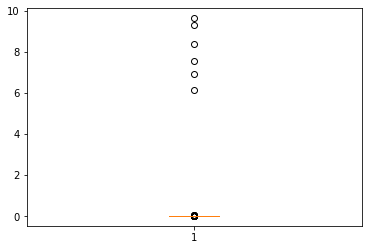

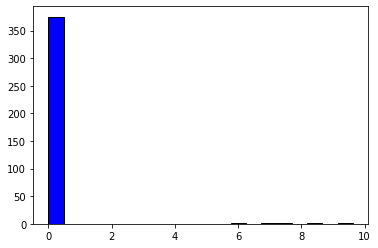

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont1)
plt.show()

plt.hist(cont1, color='blue', edgecolor='black', bins=20)
plt.show()

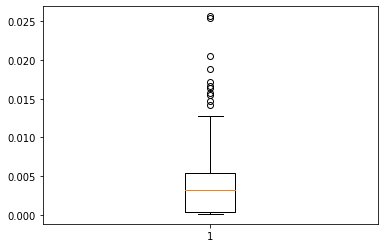

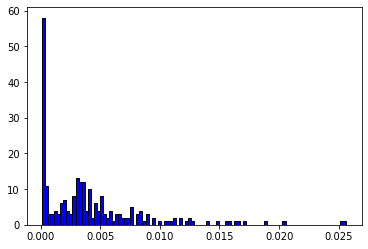

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont1_nonzero[cont1_nonzero < 5])
plt.show()

plt.hist(cont1_nonzero[cont1_nonzero < 5], color='blue', edgecolor='black', bins=100)
plt.show()

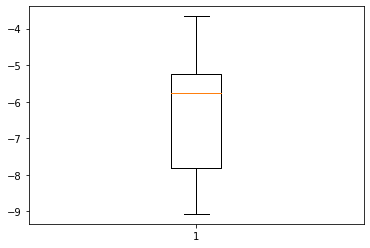

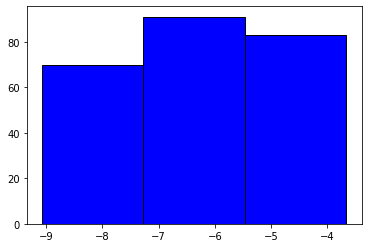

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont1_nonzero_log[cont1_nonzero_log < 0])
plt.show()

plt.hist(cont1_nonzero_log[cont1_nonzero_log < 0], color='blue', edgecolor='black', bins=3)
plt.show()

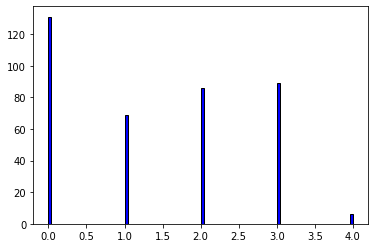

In [ ]:
def cont1_to_discrete(cont_val):
    if cont_val == 0:
        return 0
    cont_val_log = np.log(cont_val)
    if cont_val_log > 0:
        return 4
    if cont_val_log < -7.5:
        return 1
    if cont_val_log < -5.5:
        return 2
    if cont_val_log < 0:
        return 3

cont1_discrete = []
for c in cont1:
    tmp = cont1_to_discrete(c)
    cont1_discrete.append(tmp)

plt.hist(cont1_discrete, color='blue', edgecolor='black', bins=100)
plt.show()

### item cont2

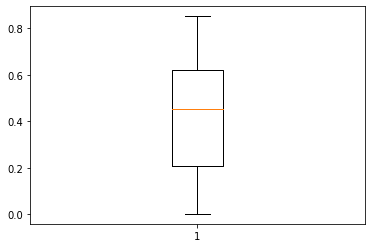

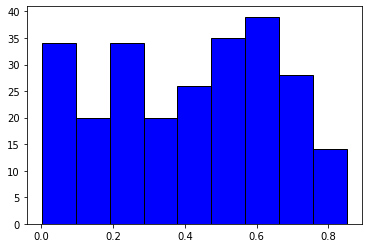

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont2[cont2 != 0])
plt.show()

plt.hist(cont2[cont2 != 0], color='blue', edgecolor='black', bins=9)
plt.show()

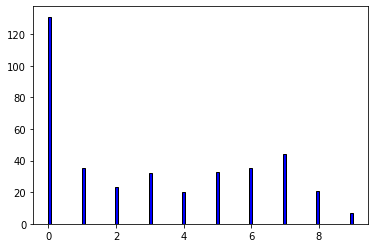

In [ ]:
def cont2_to_discrete(cont_val):
    if cont_val == 0:
        return 0
    if cont_val < 0.1:
        return 1
    if cont_val < 0.2:
        return 2
    if cont_val < 0.3:
        return 3
    if cont_val < 0.4:
        return 4
    if cont_val < 0.5:
        return 5
    if cont_val < 0.6:
        return 6
    if cont_val < 0.7:
        return 7
    if cont_val < 0.8:
        return 8
    if cont_val < 0.9:
        return 9

cont2_discrete = []
for c in cont2:
    tmp = cont2_to_discrete(c)
    cont2_discrete.append(tmp)

plt.hist(cont2_discrete, color='blue', edgecolor='black', bins=100)
plt.show()

### item cont3

In [ ]:
cont3_log = np.log(cont3)

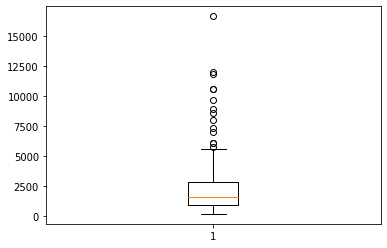

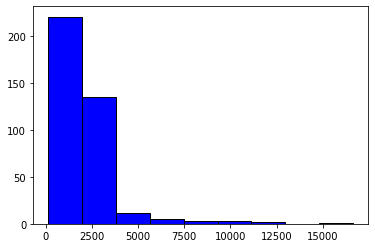

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont3)
plt.show()

plt.hist(cont3, color='blue', edgecolor='black', bins=9)
plt.show()

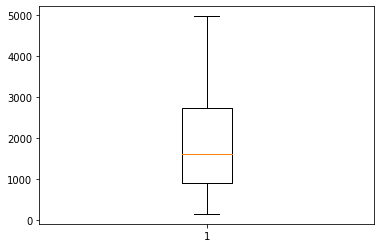

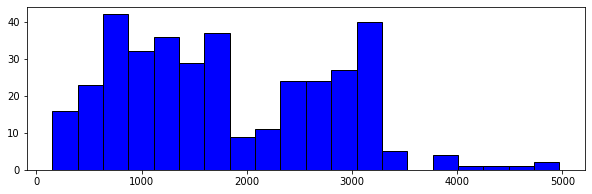

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont3[cont3 < 5000])
plt.show()

plt.figure(figsize=(10, 3))
plt.hist(cont3[cont3 < 5000], color='blue', edgecolor='black', bins=20)
plt.show()

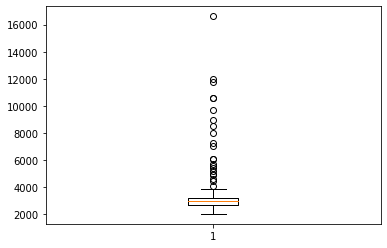

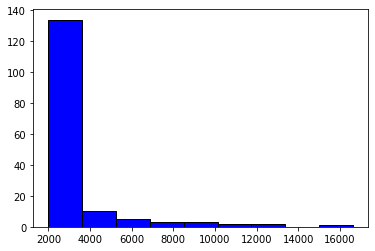

In [ ]:
fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
ax1.boxplot(cont3[cont3 >= 2000])
plt.show()

plt.hist(cont3[cont3 >= 2000], color='blue', edgecolor='black', bins=9)
plt.show()

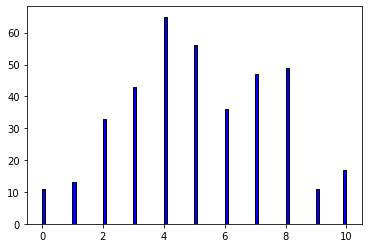

In [ ]:
## price
def cont3_to_discrete(cont_val):
    if cont_val < 300:
        return 0
    if cont_val < 500:
        return 1
    if cont_val < 750:
        return 2
    if cont_val < 1000:
        return 3
    if cont_val < 1500:
        return 4
    if cont_val < 2000:
        return 5
    if cont_val < 2500:
        return 6
    if cont_val < 3000:
        return 7
    if cont_val < 3500:
        return 8
    if cont_val <= 5000:
        return 9
    if cont_val > 5000:
        return 10

cont3_discrete = []
for c in cont3:
    tmp = cont3_to_discrete(c)
    cont3_discrete.append(tmp)

plt.hist(cont3_discrete, color='blue', edgecolor='black', bins=100)
plt.show()

## overall data cont to discrete

cont1,2,3 -> discrete 

len = [5, 10, 11]

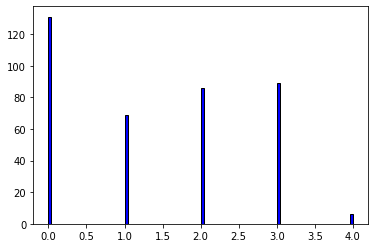

In [ ]:
def cont1_to_discrete(cont_val):
    if cont_val == 0:
        return 0
    cont_val_log = np.log(cont_val)
    if cont_val_log < -7.5:
        return 1
    if cont_val_log < -5.5:
        return 2
    if cont_val_log <= 0:
        return 3
    if cont_val_log > 0:
        return 4

cont1_discrete = []
for c in cont1:
    tmp = cont1_to_discrete(c)
    cont1_discrete.append(tmp)
assert len(cont1_discrete) == len(cont1)

plt.hist(cont1_discrete, color='blue', edgecolor='black', bins=100)
plt.show()

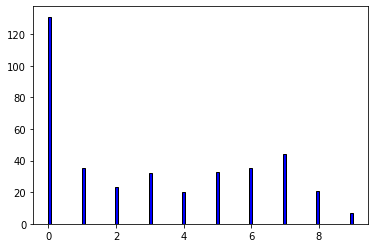

In [ ]:
def cont2_to_discrete(cont_val):
    if cont_val == 0:
        return 0
    if cont_val < 0.1:
        return 1
    if cont_val < 0.2:
        return 2
    if cont_val < 0.3:
        return 3
    if cont_val < 0.4:
        return 4
    if cont_val < 0.5:
        return 5
    if cont_val < 0.6:
        return 6
    if cont_val < 0.7:
        return 7
    if cont_val < 0.8:
        return 8
    if cont_val < 0.9:
        return 9

cont2_discrete = []
for c in cont2:
    tmp = cont2_to_discrete(c)
    cont2_discrete.append(tmp)
assert len(cont2_discrete) == len(cont2)

plt.hist(cont2_discrete, color='blue', edgecolor='black', bins=100)
plt.show()

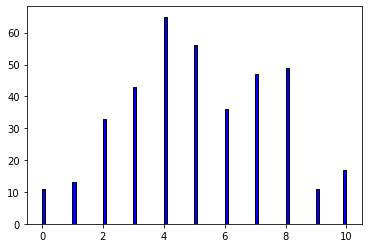

In [ ]:
## price
def cont3_to_discrete(cont_val):
    if cont_val < 300:
        return 0
    if cont_val < 500:
        return 1
    if cont_val < 750:
        return 2
    if cont_val < 1000:
        return 3
    if cont_val < 1500:
        return 4
    if cont_val < 2000:
        return 5
    if cont_val < 2500:
        return 6
    if cont_val < 3000:
        return 7
    if cont_val < 3500:
        return 8
    if cont_val <= 5000:
        return 9
    if cont_val > 5000:
        return 10

cont3_discrete = []
for c in cont3:
    tmp = cont3_to_discrete(c)
    cont3_discrete.append(tmp)
assert len(cont3_discrete) == len(cont3)

plt.hist(cont3_discrete, color='blue', edgecolor='black', bins=100)
plt.show()

In [ ]:
def load_item_info_turn_cont_to_discrete(
    data_path='/content/'
):

    # item info
    df_item_info = pd.read_parquet(f'{data_path}/item_info.parquet.snappy')

    num_items = 381+1 # 0 means no item; normal items start from 1
    num_features = (3+1) + (2+1)
    item_features = np.zeros((num_items, num_features)).astype(np.int64)

    for i in tqdm(range(num_items - 1)):
        item_id = df_item_info.at[i, 'item_id']
        # discrete
        item_discrete = df_item_info.at[i, 'item_vec'].split(',')[:3]
        loc = df_item_info.at[i, 'location'] - 1 # 0~2
        item_discrete.append(loc)
        item_discrete = [int(it) for it in item_discrete]
        item_discrete[0] = item_discrete[0] - 1 # 1~4 -> 0~3
        item_discrete[2] = item_discrete[2] - 1 # 1~2 -> 0~1

        # cont
        item_cont = df_item_info.at[i, 'item_vec'].split(',')[-2:]
        price = df_item_info.at[i, 'price']
        item_cont.append(price)
        item_cont = [float(it) for it in item_cont]

        item_cont1 = cont1_to_discrete(item_cont[0])
        item_cont2 = cont2_to_discrete(item_cont[1])
        item_cont3 = cont3_to_discrete(item_cont[2])

        # agg
        item_discrete.append(item_cont1)
        item_discrete.append(item_cont2)
        item_discrete.append(item_cont3)

        item_total_feat = np.array(item_discrete, dtype=np.int64)
        item_features[item_id] = item_total_feat
    
    # change 0 item to no-feature (last idx of each feature + 1)
    last_idx = np.max(item_features, axis=0)
    item_features[0] = last_idx + 1

    return item_features

In [ ]:
item_features = load_item_info_turn_cont_to_discrete(
    data_path='/content/'
)

100%|██████████| 381/381 [00:00<00:00, 25462.55it/s]


In [ ]:
print(item_features[:10])

[[ 4 10  2  3  5 10 11]
 [ 1  2  0  0  3  9  7]
 [ 1  0  0  0  3  8  0]
 [ 1  8  0  0  3  8  3]
 [ 1  0  0  0  3  9  4]
 [ 1  0  0  0  3  8  2]
 [ 1  7  0  0  3  8  4]
 [ 1  7  0  0  3  7  7]
 [ 1  0  0  0  3  7  0]
 [ 1  0  0  0  3  7  0]]


## data

In [ ]:
## 获取 user portrait 的映射，因为
data_path='/content/'
# portraitidx_to_idx_dict_list: list of 10 dict, int:int

portraitidx_to_idx_dict_list = []
for i in range(10):
    portraitidx_to_idx_dict_list.append(dict())
acculumated_idx = [0] * 10


df_train = pd.read_parquet(f'{data_path}/trainset.parquet.snappy')
for i in tqdm(range(df_train.shape[0])):
    user_portrait = [int(s) for s in df_train.at[i, 'user_protrait'].split(',')]
    for idx, u in enumerate(user_portrait):
        if portraitidx_to_idx_dict_list[idx].get(u, -1) == -1:
            portraitidx_to_idx_dict_list[idx][u] = acculumated_idx[idx]
            acculumated_idx[idx] += 1
print(acculumated_idx)


# 测试集中如果出现训练集里没出现的， 就统一置为最后一个
df_test1 = pd.read_parquet(f'{data_path}/track1_testset.parquet.snappy')
for i in tqdm(range(df_test1.shape[0])):
    user_portrait = [int(s) for s in df_test1.at[i, 'user_protrait'].split(',')]
    for idx, u in enumerate(user_portrait):
        if portraitidx_to_idx_dict_list[idx].get(u, -1) == -1:
            portraitidx_to_idx_dict_list[idx][u] = acculumated_idx[idx]
df_test2 = pd.read_parquet(f'{data_path}/track2_testset.parquet.snappy')
for i in tqdm(range(df_test2.shape[0])):
    user_portrait = [int(s) for s in df_test2.at[i, 'user_protrait'].split(',')]
    for idx, u in enumerate(user_portrait):
        if portraitidx_to_idx_dict_list[idx].get(u, -1) == -1:
            portraitidx_to_idx_dict_list[idx][u] = acculumated_idx[idx]

for i in range(10):
    acculumated_idx[i] += 1

# 所以最后也统一加上一个， 即使有些维度其实没有 测试集出现但训练集没出现的东西
print(acculumated_idx)

100%|██████████| 260087/260087 [00:02<00:00, 98770.11it/s] 


[3, 1363, 20, 10, 195, 49, 3, 11, 2, 2164]


100%|██████████| 206096/206096 [00:02<00:00, 97363.79it/s]

[4, 1364, 21, 11, 196, 50, 4, 12, 3, 2165]


In [ ]:
def load_train_data(data_path='/content/'):
    # trainset
    train_samples = []
    val_samples = []
    df_train = pd.read_parquet(f'{data_path}/trainset.parquet.snappy')

    # shuffle
    df_train = shuffle(df_train, random_state=2333).reset_index()
    total_num = int(df_train.shape[0])
    num_train = int(total_num * 0.95)
    num_val = total_num - num_train # 5% validation data

    for i in tqdm(range(total_num)):
        if df_train.at[i, 'user_click_history'] == '0:0':
            user_click_list = [0]
        else:
            user_click_list = df_train.at[i, 'user_click_history'].split(',')
            user_click_list = [int(sample.split(':')[0]) for sample in user_click_list]
        num_user_click_history = len(user_click_list)
        tmp = np.zeros(400, dtype=np.int64)
        tmp[:len(user_click_list)] = user_click_list
        user_click_list = tmp
        
        exposed_items = [int(s) for s in df_train.at[i, 'exposed_items'].split(',')]
        labels = [int(s) for s in df_train.at[i, 'labels'].split(',')]

        user_portrait = [int(s) for s in df_train.at[i, 'user_protrait'].split(',')]
        # portraitidx_to_idx_dict_list: list of 10 dict, int:int
        for j in range(10):
            user_portrait[j] = portraitidx_to_idx_dict_list[j][user_portrait[j]]
        one_sample = {
            'user_click_list': user_click_list,
            'num_user_click_history': num_user_click_history,
            'user_portrait': np.array(user_portrait, dtype=np.int64),
            'item_id': np.array(exposed_items, dtype=np.int64),
            'label': np.array(labels, dtype=np.int64)
        }
        if i < num_train:
            train_samples.append(one_sample)
        else:
            val_samples.append(one_sample)
    return train_samples, val_samples

In [ ]:
train_samples, val_samples = load_train_data(data_path='/content/')

100%|██████████| 260087/260087 [00:16<00:00, 15299.88it/s]


In [ ]:
# aug items within sess
from itertools import permutations
from functools import reduce
import operator
import random

perm1 = list(permutations([0, 1, 2]))
perm2 = list(permutations([3, 4, 5]))
perm3 = list(permutations([6, 7, 8]))

aug_order = []
for p1 in perm1:
    # print(p1)
    for p2 in perm2:
        # print(p1, p2)
        for p3 in perm3:
            # print(p1, p2, p3)
            tmp = reduce(operator.concat, [p1, p2, p3])
            aug_order.append(tmp)
len_aug_order = len(aug_order)


class BigDataCupDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 item_features,
                 database,
                 get_click_data=True,
                 train_val='train' # if train, use augorder
                ):
        super().__init__()
        self.item_features = item_features
        self.database = database
        self.train_val = train_val
        self.get_click_data = get_click_data

    def __len__(self, ):
        return len(self.database)

    def __getitem__(self, idx):
        one_sample = self.database[idx]
        user_click_history = one_sample['user_click_list'] # [400]
        num_user_click_history = one_sample['num_user_click_history'] # int
        user_discrete_feature = one_sample['user_portrait'] # [10]
        nine_item_id = one_sample['item_id'] # [9]
        label = one_sample['label'] # [9]

        if self.train_val == 'train':
            ao = list(aug_order[random.randint(0, len_aug_order - 1)])
            nine_item_id = nine_item_id[ao]
            label = label[ao]

        user_click_history_discrete_feature = np.zeros((400, (3+1) + (2+1))).astype(np.int64)
        for i in range(num_user_click_history):
            if user_click_history[i] == 0:
                user_click_history_discrete_feature[i] = self.item_features[user_click_history[i]]
                # 这里 0表示没有任何点击
            else:
                user_click_history_discrete_feature[i] = self.item_features[user_click_history[i]]

        nine_item_discrete_feature = np.zeros((9, (3+1) + (2+1))).astype(np.int64)
        for i in range(9):
            nine_item_discrete_feature[i] = self.item_features[nine_item_id[i]]

        session_label = 0 # 0,1,2,3
        # 0: 什么都不买
        for i in range(9):
            if label[i]: # 买1~3个
                session_label = 1
            if i >= 3 and label[i]: # 买4~6个
                session_label = 2
            if i >= 6 and label[i]: # 买7~9个
                session_label = 3

        # click
        if self.get_click_data:
            def neg_sample(): # 这里没有考虑到 buy 和 click，但就先随机吧
                return random.randint(1, 381)

            click_user_discrete_feature = user_discrete_feature
            click_user_click_history = user_click_history
            click_user_click_history_discrete_feature = user_click_history_discrete_feature
            if num_user_click_history == 1:
                click_user_click_history = user_click_history
                click_num_user_click_history = num_user_click_history
                click_item_id = neg_sample() # random sample (todo)
                click_item_discrete_feature = torch.IntTensor(self.item_features[click_item_id])
                click_label = torch.IntTensor([0])
            else: # num_user_click_history >= 2
                # random sample to a click history thre
                click_idx = random.randint(2, num_user_click_history) # 要预测的那个点击item
                click_num_user_click_history = click_idx - 1 # 预测的点击item之前有多少东西
                # pos or neg 1:4
                if random.randint(1, 3) == 1:
                    # pos
                    click_item_id = click_user_click_history[click_idx - 1]
                    click_label = torch.IntTensor([1])
                else:
                    # neg
                    click_item_id = neg_sample()
                    click_label = torch.IntTensor([0])
                click_item_discrete_feature = torch.IntTensor(self.item_features[click_item_id])

        # buy
        user_click_history = torch.IntTensor(user_click_history)
        user_click_history_discrete_feature = torch.IntTensor(user_click_history_discrete_feature)
        num_user_click_history = torch.IntTensor([num_user_click_history])
        user_discrete_feature = torch.IntTensor(user_discrete_feature)
        nine_item_id = torch.IntTensor(nine_item_id)
        nine_item_discrete_feature = torch.IntTensor(nine_item_discrete_feature)
        label = torch.IntTensor(label)
        session_label = session_label

        if not self.get_click_data:
            return user_click_history, \
                user_click_history_discrete_feature, \
                num_user_click_history, \
                nine_item_id, \
                nine_item_discrete_feature, \
                user_discrete_feature, \
                label, session_label
        else:
            # click
            click_user_click_history = torch.IntTensor(user_click_history)
            click_user_click_history_discrete_feature = torch.IntTensor(click_user_click_history_discrete_feature)
            click_num_user_click_history = torch.IntTensor([click_num_user_click_history])
            click_item_id = torch.IntTensor([click_item_id])
            click_item_discrete_feature = torch.IntTensor(click_item_discrete_feature)
            click_user_discrete_feature = torch.IntTensor(click_user_discrete_feature)
            click_label = torch.IntTensor([click_label])

            return user_click_history, \
            user_click_history_discrete_feature, \
            num_user_click_history, \
            nine_item_id, \
            nine_item_discrete_feature, \
            user_discrete_feature, \
            label, session_label, \
            click_user_click_history, \
            click_user_click_history_discrete_feature, \
            click_num_user_click_history, \
            click_item_id, \
            click_item_discrete_feature, \
            click_user_discrete_feature, \
            click_label


In [ ]:
ds = BigDataCupDataset(item_features, train_samples, get_click_data=True, train_val='train')

In [ ]:
ds[0]

(tensor([ 14,  20,  34,  21,  28,  28,  20,  32,  72,  14,  33,  14,  33,  31,
         107, 104,  86, 183,  14,  33,  32,  86, 100, 137, 200,  28,  19,  32,
          81, 125, 135, 213, 234,  28,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
train_samples, val_samples = load_train_data()

train_ds = BigDataCupDataset(item_features, train_samples, get_click_data=True, train_val='train')
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=32, shuffle=True)

val_ds = BigDataCupDataset(item_features, val_samples, get_click_data=True, train_val='val')
val_dl = torch.utils.data.DataLoader(dataset=val_ds, batch_size=32, shuffle=False)

100%|██████████| 260087/260087 [00:16<00:00, 15381.17it/s]


In [ ]:
next(iter(train_dl))

[tensor([[29, 17, 29,  ...,  0,  0,  0],
         [ 1,  2, 14,  ...,  0,  0,  0],
         [33, 10, 32,  ...,  0,  0,  0],
         ...,
         [29, 21, 14,  ...,  0,  0,  0],
         [38, 31, 31,  ...,  0,  0,  0],
         [31,  9,  2,  ...,  0,  0,  0]], dtype=torch.int32),
 tensor([[[3, 2, 0,  ..., 3, 9, 4],
          [2, 8, 0,  ..., 2, 7, 4],
          [3, 2, 0,  ..., 3, 9, 4],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[1, 2, 0,  ..., 3, 9, 7],
          [1, 0, 0,  ..., 3, 8, 0],
          [2, 4, 0,  ..., 3, 9, 1],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[3, 7, 0,  ..., 3, 8, 2],
          [1, 3, 0,  ..., 3, 8, 2],
          [3, 0, 0,  ..., 3, 7, 2],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
 

## model

### transformer

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, 
                 hidden_size,
                 qkv_size, 
                 num_heads, 
                 dropout_ratio=0.
                ):
        super().__init__()
        self.n = num_heads
        self.d = qkv_size
        self.D = hidden_size

        self.scale = self.d ** -0.5
        self.to_qkv = nn.Linear(self.D, self.n * self.d * 3, bias=False)
        self.attend = nn.Softmax(dim=-1)
        self.to_out = nn.Sequential(
            nn.Linear(self.n * self.d, self.D),
            nn.Dropout(dropout_ratio)
        )
        
    def forward(self, x):
        """
        x: BND
        output: BND
        """
        B, N, D = x.shape
        
        # get qkv
        qkv_agg = self.to_qkv(x) # BND -> BN(num_heads*qkv_size*3)
        qkv_agg = qkv_agg.chunk(3, dim=-1) # BND -> 3 * [BN(num_heads*qkv_size)]
        q = einops.rearrange(qkv_agg[0], 'B N (n d) -> B n N d', n=self.n)
        k = einops.rearrange(qkv_agg[1], 'B N (n d) -> B n N d', n=self.n)
        v = einops.rearrange(qkv_agg[2], 'B N (n d) -> B n N d', n=self.n)

        # calc self attention 
        dots = torch.einsum('Bnid, Bnjd -> Bnij', q, k)     # BnNd, BnNd -> BnNN
        attn = self.attend(dots * self.scale)
        out = torch.einsum('BnNj, Bnjd -> BnNd', attn, v)   # BnNN, BnNd -> BnNd
        out = einops.rearrange(out, 'B n N d -> B N (n d)') # BnNd -> BN(nd) = BND

        # aggregate multihead
        out = self.to_out(out)
        
        return out


class FeedForwardNetwork(nn.Module):
    def __init__(self, 
                 hidden_size,
                 mlp_size,
                 dropout_ratio
                ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(hidden_size, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout_ratio),
            nn.Linear(mlp_size, hidden_size),
            nn.Dropout(dropout_ratio)
        )

    def forward(self, x):
        """
        x: BND
        output: BND
        """
        return self.model(x)


In [ ]:
class MultitaskTransformer(nn.Module):
    def __init__(self, 
                 num_items=381,
                 hidden_size=128,
                 num_layers=3, 
                 mlp_size=64, # normally = 4 * hidden_size
                 qkv_size=32, # normally = 64 = hidden_size / num_heads
                 num_heads=4, 
                 msa_dropout_ratio=0.1, 
                 ffn_dropout_ratio=0.1, 
                 device='cpu'
                ):
        """
        除了 item_emb 之外，其余的 emb 编号都是 0 开始的
        """

        super().__init__()
        self.device = device
        self.num_items = num_items
        self.NUM_ITEM_DISCRETE_FEATURE = 3+1 + 2+1 # item_vec3+location1 + item_vec2+price1
        self.NUM_USER_DISCRETE_FEATURE = 10
        self.hidden_size = hidden_size
        self.N_buy = 1 + self.NUM_ITEM_DISCRETE_FEATURE + \
                     9 * (1 + self.NUM_ITEM_DISCRETE_FEATURE) + \
                     self.NUM_USER_DISCRETE_FEATURE
        self.N_click = 1 + self.NUM_ITEM_DISCRETE_FEATURE + \
                       1 + self.NUM_ITEM_DISCRETE_FEATURE + \
                       self.NUM_USER_DISCRETE_FEATURE

        # item emb
        self.item_emb = nn.Embedding(self.num_items + 1, self.hidden_size) # 0 表示没有记录，因此 num_items + 1

        # item discrete feature
        self.item_discrete_feature_emb_list = nn.ModuleList()
        num_unique_value_list = [4+1, 10+1, 2+1, 3+1, 5+1, 10+1, 11+1] # [4, 10, 2, 3]
        for i in range(self.NUM_ITEM_DISCRETE_FEATURE):
            num_unique_value = num_unique_value_list[i]
            self.item_discrete_feature_emb_list.append(
                nn.Embedding(num_unique_value, self.hidden_size)
            )
        
        # user discrete feature
        self.user_discrete_feature_emb_list = nn.ModuleList()
        num_unique_value_list = [4, 1364, 21, 11, 196, 50, 4, 12, 3, 2165] # (already add 1 for features in test but not in train)
        for i in range(self.NUM_USER_DISCRETE_FEATURE):
            num_unique_value = num_unique_value_list[i]
            self.user_discrete_feature_emb_list.append(
                nn.Embedding(num_unique_value, self.hidden_size)
            )
        
        # position emb
        self.position_emb_buy   = nn.Parameter(torch.randn(1, self.N_buy, self.hidden_size))
        self.position_emb_click = nn.Parameter(torch.randn(1, self.N_click, self.hidden_size))

        # transformer layers
        self.transformer_layers_buy = nn.ModuleList([])
        for _ in range(num_layers):
            self.transformer_layers_buy.append(nn.ModuleList([
                nn.Sequential( # MSA(LN(x))
                    nn.LayerNorm(self.hidden_size),
                    MultiHeadSelfAttention(self.hidden_size, qkv_size, num_heads, msa_dropout_ratio),
                ),
                nn.Sequential( # MLPs(LN(x))
                    nn.LayerNorm(self.hidden_size),
                    FeedForwardNetwork(self.hidden_size, mlp_size, ffn_dropout_ratio)
                )
            ]))
        self.transformer_layers_click = nn.ModuleList([])
        for _ in range(num_layers):
            self.transformer_layers_click.append(nn.ModuleList([
                nn.Sequential( # MSA(LN(x))
                    nn.LayerNorm(self.hidden_size),
                    MultiHeadSelfAttention(self.hidden_size, qkv_size, num_heads, msa_dropout_ratio),
                ),
                nn.Sequential( # MLPs(LN(x))
                    nn.LayerNorm(self.hidden_size),
                    FeedForwardNetwork(self.hidden_size, mlp_size, ffn_dropout_ratio)
                )
            ]))

        # session prediction head
        self.session_prediction_head = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            nn.PReLU(),
            nn.Linear(64, 4)
        )

        # buy prediction head
        self.buy_prediction_head = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            nn.PReLU(),
            nn.Linear(64, 9)
        )

        # click prediction head
        self.click_prediction_head = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            nn.PReLU(),
            nn.Linear(64, 1)
        )


    def get_item_emb_attr(self, 
                          item_id, 
                          item_discrete_feature):
        """
        param:
            item_id:               [B, 9]   (0表示没有记录，从1开始是真的item)
            item_discrete_feature: [B, 9, NUM_USER_DISCRETE_FEATURE]
        return: 
            emb_attr:
                [B(batchsize), 9, N(num_feat=1+7), D(hiddendim)]
        note: 
            above, 9 can be an arbitrary number, e.g. 400
        """
        tmp = []
        # item emb
        item_emb = self.item_emb(item_id) # [B, 9, D]
        tmp.append(torch.unsqueeze(item_emb, 2)) # [B, 9, 1, D]
        # item discrete feature emb
        for i in range(self.NUM_ITEM_DISCRETE_FEATURE):
            a = self.item_discrete_feature_emb_list[i](item_discrete_feature[:, :, i]) # [B, 9, D]
            tmp.append(torch.unsqueeze(a, 2)) # [B, 9, 1, D]
        # cat to [B, 9, N, D]
        return torch.cat(tmp, dim=2) # [B, 9, 8, D]

    def forward(self,
                user_click_history, user_click_history_discrete_feature, num_user_click_history,
                nine_item_id, nine_item_discrete_feature,
                user_discrete_feature,
                ):
        """
        用户的点击历史记录（商品的emb、离散属性）
            user_click_history: [N, 400], 最多有400个点击历史记录, 每个里面是itemid, 0表示没有记录
            user_click_history_discrete_feature: [N, 400, 3+1 + 2+1]
            num_user_click_history: [N, 1], 用户点击历史数量
        展示给用户的9个商品（商品的emb、离散属性、连续属性）
            nine_item_id: [N, 9], 商品id
            nine_item_discrete_feature: [N, 9, 3+1 + 2+1] 商品离散属性（已重映射） item_vec3 + location1 + item_vec2 + price1
        用户的属性（离散属性）
            user_discrete_feature: [B, 10] 用户离散属性（已重映射）
        """

        batch_size = user_click_history.size()[0]

        # 用户的点击历史记录（商品的emb、离散属性）
        user_click_history_emb = torch.zeros( # [B, 8, D]
            (batch_size, 1 + self.NUM_ITEM_DISCRETE_FEATURE, self.hidden_size)
        ).to(self.device)
        assert 1 + self.NUM_ITEM_DISCRETE_FEATURE == 8
        tmp = self.get_item_emb_attr(user_click_history, user_click_history_discrete_feature) # [B, 400, 8, D]
        for i in range(batch_size):
            aa = tmp[i, :num_user_click_history[i], :, :] # [B, 400, 8, D] -> [400-, 8, D]
            a = torch.mean(aa, dim=0) # [400-, 8, D] -> [8, D]
            user_click_history_emb[i] = a
        
        # 展示给用户的9个商品（商品的emb、离散属性）
        nine_item_emb = self.get_item_emb_attr(nine_item_id, nine_item_discrete_feature) # [B, 9, 8, D]
        nine_item_emb = einops.rearrange(nine_item_emb, 'B n N D -> B (n N) D') # [B, 9*8, D]

        # 用户的属性（离散属性）
        tmp = []
        for i in range(self.NUM_USER_DISCRETE_FEATURE):
            a = self.user_discrete_feature_emb_list[i](user_discrete_feature[:, i]) # [B, D]
            tmp.append(torch.unsqueeze(a, 1)) # [B, 1, D]
        user_discrete_feature_emb = torch.cat(tmp, dim=1) # [B, 10, D]

        # concat all emb
        z0 = torch.cat([user_click_history_emb,     # [B, 8, D]
                        nine_item_emb,              # [B, 9*8, D]
                        user_discrete_feature_emb,  # [B, 10, D]
                        ], dim=1) # [B, N, D]

        position_embs = einops.repeat(self.position_emb_buy, '() N D -> B N D', B=batch_size)
        z0 = z0 + position_embs

        # transformer
        zl = z0
        for transformer_layer in self.transformer_layers_buy:
            zl = zl + transformer_layer[0](zl) # MSA(LN(x))
            zl = zl + transformer_layer[1](zl) # MLPs(LN(x))

        # global average pooling
        zl = einops.reduce(zl, 'B N D -> B D', reduction='mean')

        # head
        session_pred = self.session_prediction_head(zl)
        buy_pred = self.buy_prediction_head(zl)

        return session_pred, buy_pred # [B, 4], [B, 9]


    def forward_click(self,
                      user_click_history, user_click_history_discrete_feature, num_user_click_history,
                      item_id, item_discrete_feature,
                      user_discrete_feature):
        """
        用户 之前的 点击历史记录（商品的emb、离散属性、连续属性变成离散）
            user_click_history: [N, 400], 最多有400个点击历史记录, 每个里面是itemid, 0表示没有记录
            user_click_history_discrete_feature: [N, 400, 3+1 + 2+1]
            num_user_click_history: [N, 1], 用户点击历史数量
        用户 __当前点击__ 的商品（商品的emb、离散属性、连续属性变成离散）
            item_id: [N, 1], 商品id
            item_discrete_feature: [N, 3+1 + 2+1] 商品离散属性（已重映射） item_vec3 + location1 + item_vec2 + price1
        用户的属性（离散属性）
            user_discrete_feature: [B, 10] 用户离散属性（已重映射）

        输出：
        1. 用户是否点击这个商品
        
        """
        batch_size = user_click_history.size()[0]

        # 用户的点击历史记录（商品的emb、离散属性）
        user_click_history_emb = torch.zeros( # [B, 7+1, D]
            (batch_size, 1 + self.NUM_ITEM_DISCRETE_FEATURE, self.hidden_size)
        ).to(self.device)
        assert 1 + self.NUM_ITEM_DISCRETE_FEATURE == 8
        # print(user_click_history.device, user_click_history_discrete_feature.device, flush=True)
        tmp = self.get_item_emb_attr(user_click_history, user_click_history_discrete_feature) # [B, 400, 8, D]
        for i in range(batch_size):
            aa = tmp[i, :num_user_click_history[i], :, :] # [B, 400, 8, D] -> [400-, 8, D]
            a = torch.mean(aa, dim=0) # [400-, 8, D] -> [8, D]
            user_click_history_emb[i] = a
        
        # 用户 __当前点击__ 的商品（商品的emb、离散属性）
        item_discrete_feature = torch.unsqueeze(item_discrete_feature, dim=1) # [B, 7] -> [B, 1, 7]
        # print(item_id.shape, item_discrete_feature.shape)
        item_emb = self.get_item_emb_attr(item_id, item_discrete_feature) # [B, 1, 8, D]
        item_emb = einops.rearrange(item_emb, 'B n N D -> B (n N) D') # [B, 1*8, D]

        # 用户的属性（离散属性）
        tmp = []
        for i in range(self.NUM_USER_DISCRETE_FEATURE):
            a = self.user_discrete_feature_emb_list[i](user_discrete_feature[:, i]) # [B, D]
            tmp.append(torch.unsqueeze(a, 1)) # [B, 1, D]
        user_discrete_feature_emb = torch.cat(tmp, dim=1) # [B, 10, D]

        # concat all emb
        z0 = torch.cat([user_click_history_emb,     # [B, 8, D]
                        item_emb,              # [B, 1*8, D]
                        user_discrete_feature_emb,  # [B, 10, D]
                        ], dim=1) # [B, N, D]

        position_embs = einops.repeat(self.position_emb_click, '() N D -> B N D', B=batch_size)
        z0 = z0 + position_embs

        # transformer
        zl = z0
        for transformer_layer in self.transformer_layers_click:
            zl = zl + transformer_layer[0](zl) # MSA(LN(x))
            zl = zl + transformer_layer[1](zl) # MLPs(LN(x))

        # global average pooling
        zl = einops.reduce(zl, 'B N D -> B D', reduction='mean')

        # head
        click_pred = self.click_prediction_head(zl)

        return click_pred # [B, 1]


In [ ]:
m = MultitaskTransformer(
    num_items=381,
    hidden_size=128,
    num_layers=3, 
    mlp_size=64, # normally = 4 * hidden_size
    qkv_size=32, # normally = 64 = hidden_size / num_heads
    num_heads=4, 
    msa_dropout_ratio=0.1, 
    ffn_dropout_ratio=0.1, 
    device='cuda'
)
m = m.to('cuda')

B = 3
a = m(
    user_click_history=torch.ones([B, 400], dtype=torch.int32).cuda(),
    user_click_history_discrete_feature=torch.ones([B, 400, 7], dtype=torch.int32).cuda(),
    num_user_click_history=torch.ones([B, 1], dtype=torch.int32).cuda() * 10,
    user_discrete_feature=torch.ones([B, 10], dtype=torch.int32).cuda(),
    nine_item_id=torch.ones([B, 9], dtype=torch.int32).cuda(),
    nine_item_discrete_feature=torch.ones([B, 9, 7], dtype=torch.int32).cuda(),
)
print(a)

b = m.forward_click(
    user_click_history=torch.ones([B, 400], dtype=torch.int32).cuda(),
    user_click_history_discrete_feature=torch.ones([B, 400, 7], dtype=torch.int32).cuda(),
    num_user_click_history=torch.ones([B, 1], dtype=torch.int32).cuda() * 10,
    user_discrete_feature=torch.ones([B, 10], dtype=torch.int32).cuda(),
    item_id=torch.ones([B, 1], dtype=torch.int32).cuda(),
    item_discrete_feature=torch.ones([B, 7], dtype=torch.int32).cuda(),
)
print(b)

(tensor([[-0.1304,  0.1264,  0.0343, -0.0283],
        [-0.1473,  0.1203,  0.0343, -0.0342],
        [-0.1419,  0.1202,  0.0390, -0.0435]], device='cuda:0',
       grad_fn=<AddmmBackward>), tensor([[ 0.0914, -0.0263,  0.1005,  0.0078, -0.0815,  0.0474,  0.0286,  0.0280,
         -0.3035],
        [ 0.0947, -0.0134,  0.1019,  0.0182, -0.0888,  0.0532,  0.0417,  0.0208,
         -0.3038],
        [ 0.0872, -0.0221,  0.1106,  0.0211, -0.0725,  0.0380,  0.0364,  0.0222,
         -0.3063]], device='cuda:0', grad_fn=<AddmmBackward>))
tensor([[0.1455],
        [0.1450],
        [0.1383]], device='cuda:0', grad_fn=<AddmmBackward>)


## train

In [ ]:
model_name = 'multitask_transformer_augorder_adamlr0.001_epoch10'
tb_path = 'runs/%s-%s' % (datetime.today().strftime('%Y-%m-%d-%H:%M:%S'), model_name)
tb_writer = SummaryWriter(tb_path)

In [ ]:
device = 'cuda'
model = MultitaskTransformer(
    num_items=381,
    hidden_size=128,
    num_layers=3, 
    mlp_size=64, # normally = 4 * hidden_size
    qkv_size=32, # normally = 64 = hidden_size / num_heads
    num_heads=4, 
    msa_dropout_ratio=0.1, 
    ffn_dropout_ratio=0.1, 
    device='cuda'
)
model = model.to(device)

In [ ]:
def binary_acc(sess_pred, y_pred, y_test):
    # print(sess_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred_tag_intact = y_pred_tag.clone()


    ##################################
    ## vanilla
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc1 = correct_results_sum / y_test.shape[0] / 9

    real_acc1 = 0.0
    for i in range(y_test.shape[0]):
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        one_acc = correct_results_sum / 9
        if one_acc == 1:
            real_acc1 += 1
    real_acc1 = real_acc1 / y_test.shape[0]
    # print(y_pred_tag)

    ####################################
    ## use sess to refine y_pred_tag
    for i in range(y_test.shape[0]):
        if sess_pred[i] == 0:
            y_pred_tag[i][:] = 0
        elif sess_pred[i] == 1:
            y_pred_tag[i][3:] = 0
        elif sess_pred[i] == 2:
            y_pred_tag[i][:3] = 1
            y_pred_tag[i][6:] = 0
        elif sess_pred[i] == 3:
            y_pred_tag[i][:6] = 1

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc2 = correct_results_sum / y_test.shape[0] / 9

    real_acc2 = 0.0
    for i in range(y_test.shape[0]):
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        one_acc = correct_results_sum / 9
        if one_acc == 1:
            real_acc2 += 1
    real_acc2 = real_acc2 / y_test.shape[0]
    # print(y_pred_tag)

    #######################################
    ## rule 2
    y_pred_tag = y_pred_tag_intact
    acc_rule2 = 0.0
    real_acc_rule2 = 0.0
    for i in range(y_test.shape[0]):
        for j in range(9):
            k = 8 - j
            if k >= 6 and y_pred_tag[i][k] == 1:
                y_pred_tag[i][:6] = 1
            if k >= 3 and y_pred_tag[i][k] == 1:
                y_pred_tag[i][:3] = 1
        
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        a = correct_results_sum / 9
        acc_rule2 += a
        if a == 1:
            real_acc_rule2 += 1
    acc_rule2 = acc_rule2 / y_test.shape[0]
    real_acc_rule2 = real_acc_rule2 / y_test.shape[0]
    # print(y_pred_tag)


    return acc1, acc2, acc_rule2, real_acc1, real_acc2, real_acc_rule2

In [ ]:
def click_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc

In [ ]:
sess_criterion = nn.CrossEntropyLoss()
buy_criterion = nn.BCEWithLogitsLoss()
click_criterion = nn.BCEWithLogitsLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
NUM_EPOCH = 10

batches_done = 0
best_val_acc = 0

In [ ]:
# for epoch_idx in range(NUM_EPOCH):  # loop over the dataset multiple times
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
for epoch_idx in range(10, 20):  # loop over the dataset multiple times

    train_running_sess_loss = 0.0
    train_running_buy_loss = 0.0
    train_running_click_loss = 0.0
    train_cnt = 0
    train_click_acc = 0
    train_sess_acc_sum = 0
    train_buy_acc1_sum = 0
    train_buy_real_acc1_sum = 0
    train_buy_acc2_sum = 0
    train_buy_real_acc2_sum = 0
    train_buy_acc_rule2_sum = 0
    train_buy_real_acc_rule2_sum = 0
    train_cnt_session_0 = train_cnt_session_1 = train_cnt_session_2 = train_cnt_session_3 = 0
    
    for i, data in enumerate(train_dl, 0):
        model.train()

        # get the inputs; data is a list of [inputs, labels]
        user_click_history, \
            user_click_history_discrete_feature, \
            num_user_click_history, \
            item_id, item_discrete_feature, \
            user_discrete_feature, label, session_label, \
            click_user_click_history, \
            click_user_click_history_discrete_feature, \
            click_num_user_click_history, \
            click_item_id, \
            click_item_discrete_feature, \
            click_user_discrete_feature, \
            click_label = data
        
        user_click_history = user_click_history.to(device)
        user_click_history_discrete_feature = user_click_history_discrete_feature.to(device)
        num_user_click_history = num_user_click_history.to(device)
        item_id = item_id.to(device)
        item_discrete_feature = item_discrete_feature.to(device)
        user_discrete_feature = user_discrete_feature.to(device)
        label = label.to(device)
        session_label = session_label.to(device)

        click_user_click_history = click_user_click_history.to(device)
        click_user_click_history_discrete_feature = click_user_click_history_discrete_feature.to(device)
        click_num_user_click_history = click_num_user_click_history.to(device)
        click_item_id = click_item_id.to(device)
        click_item_discrete_feature = click_item_discrete_feature.to(device)
        click_user_discrete_feature = click_user_discrete_feature.to(device)
        click_label = click_label.to(device)

        train_batch_size = user_click_history.shape[0]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        sess_outputs, buy_outputs = model(
            user_click_history,
            user_click_history_discrete_feature,
            num_user_click_history,
            item_id,
            item_discrete_feature,
            user_discrete_feature
        )
        click_outputs = model.forward_click(
            click_user_click_history,
            click_user_click_history_discrete_feature,
            click_num_user_click_history,
            click_item_id,
            click_item_discrete_feature,
            click_user_discrete_feature
        )

        sess_loss = sess_criterion(sess_outputs, session_label)
        buy_loss = buy_criterion(buy_outputs, label.float())
        click_loss = click_criterion(click_outputs, click_label.float())
        loss = 0.1 * sess_loss + 0.8 * buy_loss + 0.1 * click_loss
        # loss = click_loss

        loss.backward()
        optimizer.step()

        # print statistics
        train_running_sess_loss += sess_loss.item()
        train_running_buy_loss += buy_loss.item()
        train_running_click_loss += click_loss.item()

        _, sess_predicted = torch.max(sess_outputs.data, 1)
        sess_acc = (sess_predicted == session_label).sum().item() / train_batch_size
        # buy_acc1, buy_acc2, buy_real_acc1, buy_real_acc2 = binary_acc(sess_predicted, buy_outputs, label)
        buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc(sess_predicted, buy_outputs, label)

        train_click_acc += click_acc(click_outputs, click_label)

        train_sess_acc_sum += sess_acc
        train_buy_acc1_sum += buy_acc1
        train_buy_real_acc1_sum += buy_real_acc1
        train_buy_acc2_sum += buy_acc2
        train_buy_real_acc2_sum += buy_real_acc2
        train_buy_acc_rule2_sum += buy_acc_rule2
        train_buy_real_acc_rule2_sum += buy_real_acc_rule2
        train_cnt += 1

        # train_cnt_session_0 += torch.sum(session_label == 0)
        # train_cnt_session_1 += torch.sum(session_label == 1)
        # train_cnt_session_2 += torch.sum(session_label == 2)
        # train_cnt_session_3 += torch.sum(session_label == 3)

        batches_done += 1

        if i % 50 == 1:
            print(i, end=' ')

        if i % 500 == 1 and i != 1:    # print every 2000 mini-batches
            print('----- TRAIN -----')
            print('[%d, %5d] sess loss: %.3f' % (epoch_idx + 1, i + 1, train_running_sess_loss / train_cnt))
            print('[%d, %5d] buy loss: %.3f'  % (epoch_idx + 1, i + 1, train_running_buy_loss / train_cnt))
            print('[%d, %5d] click loss: %.3f'  % (epoch_idx + 1, i + 1, train_running_click_loss / train_cnt))
            print('- sess acc:',      train_sess_acc_sum / train_cnt, flush=True)
            print('- buy acc1:',      train_buy_acc1_sum.cpu().item() / train_cnt, flush=True)
            print('- buy real acc1:', train_buy_real_acc1_sum / train_cnt, flush=True)
            print('- buy acc2:',      train_buy_acc2_sum.cpu().item() / train_cnt, flush=True)
            print('- buy real acc2:', train_buy_real_acc2_sum / train_cnt, flush=True)
            print('- buy acc rule2:', train_buy_acc_rule2_sum.cpu().item() / train_cnt, flush=True)
            print('- buy real acc rule2:', train_buy_real_acc_rule2_sum / train_cnt, flush=True)
            print('- click acc:', train_click_acc / train_cnt, flush=True)
            # print('- train sess cnt:', train_cnt_session_0, train_cnt_session_1, train_cnt_session_2, train_cnt_session_3)

            tb_writer.add_scalar('train/sess loss', train_running_sess_loss / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy loss',  train_running_buy_loss / train_cnt, batches_done)
            tb_writer.add_scalar('train/click loss',  train_running_click_loss / train_cnt, batches_done)
            tb_writer.add_scalar('train/sess acc',  train_sess_acc_sum / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy acc1',  train_buy_acc1_sum.cpu().item() / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy real acc1', train_buy_real_acc1_sum / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy acc2',      train_buy_acc2_sum.cpu().item() / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy real acc2', train_buy_real_acc2_sum / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy acc rule2', train_buy_acc_rule2_sum.cpu().item() / train_cnt, batches_done)
            tb_writer.add_scalar('train/buy real acc rule2', train_buy_real_acc_rule2_sum / train_cnt, batches_done)
            tb_writer.add_scalar('train/click acc',  train_click_acc / train_cnt, batches_done)
            
            train_running_sess_loss = 0.0
            train_running_buy_loss = 0.0
            train_running_click_loss = 0.0
            train_cnt = 0
            train_click_acc = 0
            train_sess_acc_sum = 0
            train_buy_acc1_sum = 0
            train_buy_real_acc1_sum = 0
            train_buy_acc2_sum = 0
            train_buy_real_acc2_sum = 0
            train_buy_acc_rule2_sum = 0
            train_buy_real_acc_rule2_sum = 0
            train_cnt_session_0 = train_cnt_session_1 = train_cnt_session_2 = train_cnt_session_3 = 0

            ## val
            model.eval()
            valid_running_sess_loss = 0.0
            valid_running_buy_loss = 0.0
            valid_running_click_loss = 0.0
            valid_cnt = 0
            valid_click_acc = 0
            valid_sess_acc_sum = 0
            valid_buy_acc1_sum = 0
            valid_buy_real_acc1_sum = 0
            valid_buy_acc2_sum = 0
            valid_buy_real_acc2_sum = 0
            valid_buy_acc_rule2_sum = 0
            valid_buy_real_acc_rule2_sum = 0
            
            valid_cnt_session_0 = valid_cnt_session_1 = valid_cnt_session_2 = valid_cnt_session_3 = 0

            for _, val_data in tqdm(enumerate(val_dl, 0)):
                user_click_history, \
                    user_click_history_discrete_feature, \
                    num_user_click_history, \
                    item_id, item_discrete_feature, \
                    user_discrete_feature, label, session_label, \
                    click_user_click_history, \
                    click_user_click_history_discrete_feature, \
                    click_num_user_click_history, \
                    click_item_id, \
                    click_item_discrete_feature, \
                    click_user_discrete_feature, \
                    click_label = val_data

                user_click_history = user_click_history.to(device)
                user_click_history_discrete_feature = user_click_history_discrete_feature.to(device)
                num_user_click_history = num_user_click_history.to(device)
                item_id = item_id.to(device)
                item_discrete_feature = item_discrete_feature.to(device)
                user_discrete_feature = user_discrete_feature.to(device)
                label = label.to(device)
                session_label = session_label.to(device)

                click_user_click_history = click_user_click_history.to(device)
                click_user_click_history_discrete_feature = click_user_click_history_discrete_feature.to(device)
                click_num_user_click_history = click_num_user_click_history.to(device)
                click_item_id = click_item_id.to(device)
                click_item_discrete_feature = click_item_discrete_feature.to(device)
                click_user_discrete_feature = click_user_discrete_feature.to(device)
                click_label = click_label.to(device)


                sess_outputs, buy_outputs = model(
                    user_click_history,
                    user_click_history_discrete_feature,
                    num_user_click_history,
                    item_id,
                    item_discrete_feature,
                    user_discrete_feature
                )
                click_outputs = model.forward_click(
                    click_user_click_history,
                    click_user_click_history_discrete_feature,
                    click_num_user_click_history,
                    click_item_id,
                    click_item_discrete_feature,
                    click_user_discrete_feature
                )

                sess_loss = sess_criterion(sess_outputs, session_label)
                buy_loss = buy_criterion(buy_outputs, label.float())
                click_loss = click_criterion(click_outputs, click_label.float())

                valid_running_sess_loss += sess_loss.item()
                valid_running_buy_loss += buy_loss.item()
                valid_running_click_loss += click_loss.item()

                valid_batch_size = user_click_history.shape[0]

                _, sess_predicted = torch.max(sess_outputs.data, 1)
                sess_acc = (sess_predicted == session_label).sum().item() / valid_batch_size
                buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc(sess_predicted, buy_outputs, label)

                valid_click_acc += click_acc(click_outputs, click_label)

                valid_sess_acc_sum += sess_acc
                valid_buy_acc1_sum += buy_acc1
                valid_buy_real_acc1_sum += buy_real_acc1
                valid_buy_acc2_sum += buy_acc2
                valid_buy_real_acc2_sum += buy_real_acc2
                valid_buy_acc_rule2_sum += buy_acc_rule2
                valid_buy_real_acc_rule2_sum += buy_real_acc_rule2
                valid_cnt += 1

                # valid_cnt_session_0 += torch.sum(session_label == 0)
                # valid_cnt_session_1 += torch.sum(session_label == 1)
                # valid_cnt_session_2 += torch.sum(session_label == 2)
                # valid_cnt_session_3 += torch.sum(session_label == 3)

            valid_acc = valid_buy_real_acc2_sum / valid_cnt
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                valid_acc = round(valid_acc, 6)
                with open(f'{tb_path}/val_best_acc.txt', 'w') as fp:
                    print('epoch:', epoch_idx, file=fp)
                    print('batches_done:', batches_done, file=fp)
                    print('buy real acc2:', valid_acc, file=fp)
                torch.save(model, f'{tb_path}/val_best.pth')

            print('----- VAL -----')
            print('- sess loss:', valid_running_sess_loss / valid_cnt)
            print('- buy loss:',  valid_running_buy_loss / valid_cnt)
            print('- click loss:',  valid_running_click_loss / valid_cnt)
            print('- sess acc:',      valid_sess_acc_sum / valid_cnt)
            print('- buy acc1:',      valid_buy_acc1_sum.cpu().item() / valid_cnt)
            print('- buy real acc1:', valid_buy_real_acc1_sum / valid_cnt)
            print('- buy acc2:',      valid_buy_acc2_sum.cpu().item() / valid_cnt)
            print('- buy real acc2:', valid_buy_real_acc2_sum / valid_cnt)
            print('- buy acc rule2:', valid_buy_acc_rule2_sum.cpu().item() / valid_cnt)
            print('- buy real acc rule2:', valid_buy_real_acc_rule2_sum / valid_cnt)
            print('- click acc:',      valid_click_acc / valid_cnt)
            # print('valid sess cnt:', valid_cnt_session_0, valid_cnt_session_1, valid_cnt_session_2, valid_cnt_session_3)

            tb_writer.add_scalar('val/sess loss', valid_running_sess_loss / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy loss',  valid_running_buy_loss / valid_cnt, batches_done)
            tb_writer.add_scalar('val/click loss',  valid_running_click_loss / valid_cnt, batches_done)
            tb_writer.add_scalar('val/sess acc',  valid_sess_acc_sum / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy acc1',  valid_buy_acc1_sum.cpu().item() / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy real acc1', valid_buy_real_acc1_sum / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy acc2',      valid_buy_acc2_sum.cpu().item() / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy real acc2', valid_buy_real_acc2_sum / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy acc rule2', valid_buy_acc_rule2_sum.cpu().item() / valid_cnt, batches_done)
            tb_writer.add_scalar('val/buy real acc rule2', valid_buy_real_acc_rule2_sum / valid_cnt, batches_done)
            tb_writer.add_scalar('val/click acc',  valid_click_acc / valid_cnt, batches_done)

print('Finished Training')

In [ ]:
# torch.save(model, f'{tb_path}/model_epoch10.pth')
torch.save(model, f'{tb_path}/model_epoch20.pth')

## test

In [ ]:
def load_test_data(data_path='/content/',
                   filename='track1_testset.csv'):
    test_samples = []
    df_test = pd.read_parquet(f'{data_path}/{filename}', sep=' ')

    total_num = int(df_test.shape[0])

    for i in tqdm(range(total_num)):
        if df_test.at[i, 'user_click_history'] == '0:0':
            user_click_list = [0]
        else:
            user_click_list = df_test.at[i, 'user_click_history'].split(',')
            user_click_list = [int(sample.split(':')[0]) for sample in user_click_list]
        num_user_click_history = len(user_click_list)
        tmp = np.zeros(400, dtype=np.int64)
        tmp[:len(user_click_list)] = user_click_list
        user_click_list = tmp
        
        exposed_items = [int(s) for s in df_test.at[i, 'exposed_items'].split(',')]

        user_portrait = [int(s) for s in df_test.at[i, 'user_protrait'].split(',')]
        # portraitidx_to_idx_dict_list: list of 10 dict, int:int
        for j in range(10):
            user_portrait[j] = portraitidx_to_idx_dict_list[j][user_portrait[j]]
        one_sample = {
            'user_click_list': user_click_list,
            'num_user_click_history': num_user_click_history,
            'user_portrait': np.array(user_portrait, dtype=np.int64),
            'item_id': np.array(exposed_items, dtype=np.int64),
        }
        test_samples.append(one_sample)
    return test_samples



class BigDataCupTestDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 item_features,
                 database
                ):
        super().__init__()
        self.item_features = item_features
        self.database = database

    def __len__(self, ):
        return len(self.database)

    def __getitem__(self, idx):
        one_sample = self.database[idx]
        user_click_history = one_sample['user_click_list']
        num_user_click_history = one_sample['num_user_click_history']
        user_discrete_feature = one_sample['user_portrait']
        item_id = one_sample['item_id']

        user_click_history_discrete_feature = np.zeros((400, 3+1 + 2+1)).astype(np.int64)
        for i in range(num_user_click_history):
            if user_click_history[i] == 0:
                user_click_history_discrete_feature[i] = self.item_features[user_click_history[i]]
            else:
                user_click_history_discrete_feature[i] = self.item_features[user_click_history[i]]

        item_discrete_feature = np.zeros((9, 3+1 + 2+1)).astype(np.int64)
        for i in range(9):
            item_discrete_feature[i] = self.item_features[item_id[i]]

        user_click_history = torch.IntTensor(user_click_history)
        user_click_history_discrete_feature = torch.IntTensor(user_click_history_discrete_feature)
        num_user_click_history = torch.IntTensor([num_user_click_history])
        user_discrete_feature = torch.IntTensor(user_discrete_feature)
        item_id = torch.IntTensor(item_id)
        item_discrete_feature = torch.IntTensor(item_discrete_feature)

        return user_click_history, \
            user_click_history_discrete_feature, \
            num_user_click_history, \
            item_id, item_discrete_feature, \
            user_discrete_feature


In [ ]:
test_samples = load_test_data(data_path='/content/', 
                                              filename='track1_testset.csv')

test_ds = BigDataCupTestDataset(item_features, test_samples)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32, shuffle=False)

100%|██████████| 206254/206254 [00:11<00:00, 17870.75it/s]


In [ ]:
# tb_path = 'runs/2021-08-16-07:50:46-4sess_pred_item_feat_extracion_deepermodel_augorder_adamlr0.001_epoch10_lr0.0001_epoch20'
# tb_path = 'runs/2021-08-18-17:25:49-4sess_pred_item_feat_extracion_deepermodel_augorder_itemalldiscretefeat_adamlr0.001_epoch30_lr0.0001_epoch50'
# tb_path = 'runs/2021-08-19-14:52:47-transformer_augorder_itemalldiscretefeat_adamlr0.001_epoch30'
tb_path = 'runs/2021-08-20-11:39:18-multitask_transformer_augorder_adamlr0.001_epoch10_lr0.0001_epoch20'

# model = torch.load(f'{tb_path}/model_0.0001.pth', map_location='cpu')
# model = torch.load(f'{tb_path}/model.pth', map_location='cpu')
model = torch.load(f'{tb_path}/val_best.pth', map_location='cpu')

model = model.eval()
model = model.to('cpu')
model.device = 'cpu'

In [ ]:
tta_augorder = False

# aug items within sess
from itertools import permutations
from functools import reduce
import operator
import random

perm1 = list(permutations([0, 1, 2]))
perm2 = list(permutations([3, 4, 5]))
perm3 = list(permutations([6, 7, 8]))

aug_order = []
for p1 in perm1:
    # print(p1)
    for p2 in perm2:
        # print(p1, p2)
        for p3 in perm3:
            # print(p1, p2, p3)
            tmp = reduce(operator.concat, [p1, p2, p3])
            aug_order.append(tmp)
len_aug_order = len(aug_order)

In [ ]:
# fp = open(f'{tb_path}/output_test_tta_augorder3_val_best.csv', 'w')
fp = open(f'{tb_path}/output_test_val_best.csv', 'w')
print('id,category', file=fp)

bs = 32

for i, data in tqdm(enumerate(test_dl, 0)):
    user_click_history, \
        user_click_history_discrete_feature, \
        num_user_click_history, \
        item_id, item_discrete_feature, \
        user_discrete_feature = data
    

    if not tta_augorder:
        sess_outputs, buy_outputs = model(
            user_click_history,
            user_click_history_discrete_feature,
            num_user_click_history,
            item_id,
            item_discrete_feature,
            user_discrete_feature
        )

        y_pred_tag = torch.round(torch.sigmoid(buy_outputs))
        _, sess_pred = torch.max(sess_outputs.data, 1)


    else:
        sum_sess_outputs = None
        sum_buy_outputs = None

        total_aug_num = 3
        aug_order_shuffle = shuffle(aug_order)
        aug_order_shuffle = aug_order_shuffle[:total_aug_num]
        for aug_idx, ao in enumerate(aug_order_shuffle):
            ao = list(ao)
            ao_inv = np.argsort(ao)
            sess_outputs, buy_outputs = model(
                user_click_history,
                user_click_history_discrete_feature,
                num_user_click_history,
                item_id[:, ao],
                item_discrete_feature[:, ao, :],
                user_discrete_feature
            )
            buy_outputs = buy_outputs[:, ao_inv]
            if aug_idx == 0:
                sum_sess_outputs = nn.functional.softmax(sess_outputs, dim=1)
                sum_buy_outputs = torch.sigmoid(buy_outputs)
            else:
                sum_sess_outputs += nn.functional.softmax(sess_outputs, dim=1)
                sum_buy_outputs += torch.sigmoid(buy_outputs)
        sess_outputs = sum_sess_outputs / total_aug_num
        buy_outputs = sum_buy_outputs / total_aug_num

        y_pred_tag = torch.round(buy_outputs)
        _, sess_pred = torch.max(sess_outputs.data, 1)

    for j in range(y_pred_tag.shape[0]):
        if sess_pred[j] == 0:
            y_pred_tag[j][:] = 0
        elif sess_pred[j] == 1:
            y_pred_tag[j][3:] = 0
        elif sess_pred[j] == 2:
            y_pred_tag[j][:3] = 1
            y_pred_tag[j][6:] = 0
        elif sess_pred[j] == 3:
            y_pred_tag[j][:6] = 1

        tmp = list(y_pred_tag[j].detach().numpy().astype(np.int32))
        tmp = [str(a) for a in tmp]
        p = ' '.join(tmp)
        print(f'{i * bs + j + 1},{p}', file=fp)
    # break

fp.close()

6446it [06:56, 15.47it/s]


In [ ]:
tta_augorder

True

In [ ]:
!tail /content/drive/MyDrive/202108-bigdatacup2021/runs/2021-08-20-11:39:18-multitask_transformer_augorder_adamlr0.001_epoch10/output_test_tta_augorder3_val_best.csv

206245,1 1 1 1 1 0 0 0 0
206246,1 1 1 1 1 1 1 0 0
206247,1 1 1 1 1 1 0 0 0
206248,1 1 1 1 1 1 0 0 0
206249,0 0 0 0 0 0 0 0 0
206250,1 1 1 1 1 1 1 1 1
206251,1 1 1 0 0 0 0 0 0
206252,1 0 0 0 0 0 0 0 0
206253,1 0 0 0 0 0 0 0 0
206254,0 0 0 0 0 0 0 0 0


## validation analysis

In [ ]:
m = torch.load('4sess_pred_item_feat_extracion_deepermodel_epoch2.pth', map_location='cpu')
m.device = 'cpu'

In [ ]:
m = model.eval()
m = model.to('cpu')
m.device = 'cpu'

In [ ]:
train_samples, val_samples = load_train_data()

# train_ds = BigDataCupDataset(item_info_dict, train_samples)
# train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=32, shuffle=True)

val_ds = BigDataCupDataset(item_info_dict, val_samples, train_val='val')
val_dl = torch.utils.data.DataLoader(dataset=val_ds, batch_size=32, shuffle=False)

100%|██████████| 260087/260087 [00:18<00:00, 14386.48it/s]


### tta, augorder

In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9])

In [ ]:
permutation = list(aug_order[100])
permutation

[1, 0, 2, 5, 3, 4, 8, 6, 7]

In [ ]:
np.argsort(permutation)

array([1, 0, 2, 4, 5, 3, 7, 8, 6])

In [ ]:
a[permutation]

array([2, 1, 3, 6, 4, 5, 9, 7, 8])

In [ ]:
a[permutation][np.argsort(permutation)]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
def binary_acc_nosigmoid(sess_pred, y_pred, y_test):
    # print(sess_pred)
    y_pred_tag = torch.round(y_pred)
    y_pred_tag_intact = y_pred_tag.clone()


    ##################################
    ## vanilla
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc1 = correct_results_sum / y_test.shape[0] / 9

    real_acc1 = 0.0
    for i in range(y_test.shape[0]):
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        one_acc = correct_results_sum / 9
        if one_acc == 1:
            real_acc1 += 1
    real_acc1 = real_acc1 / y_test.shape[0]
    # print(y_pred_tag)

    ####################################
    ## use sess to refine y_pred_tag
    for i in range(y_test.shape[0]):
        if sess_pred[i] == 0:
            y_pred_tag[i][:] = 0
        elif sess_pred[i] == 1:
            y_pred_tag[i][3:] = 0
        elif sess_pred[i] == 2:
            y_pred_tag[i][:3] = 1
            y_pred_tag[i][6:] = 0
        elif sess_pred[i] == 3:
            y_pred_tag[i][:6] = 1

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc2 = correct_results_sum / y_test.shape[0] / 9

    real_acc2 = 0.0
    for i in range(y_test.shape[0]):
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        one_acc = correct_results_sum / 9
        if one_acc == 1:
            real_acc2 += 1
    real_acc2 = real_acc2 / y_test.shape[0]
    # print(y_pred_tag)

    #######################################
    ## rule 2
    y_pred_tag = y_pred_tag_intact
    acc_rule2 = 0.0
    real_acc_rule2 = 0.0
    for i in range(y_test.shape[0]):
        for j in range(9):
            k = 8 - j
            if k >= 6 and y_pred_tag[i][k] == 1:
                y_pred_tag[i][:6] = 1
            if k >= 3 and y_pred_tag[i][k] == 1:
                y_pred_tag[i][:3] = 1
        
        correct_results_sum = (y_pred_tag[i] == y_test[i]).sum().float()
        a = correct_results_sum / 9
        acc_rule2 += a
        if a == 1:
            real_acc_rule2 += 1
    acc_rule2 = acc_rule2 / y_test.shape[0]
    real_acc_rule2 = real_acc_rule2 / y_test.shape[0]
    # print(y_pred_tag)


    return acc1, acc2, acc_rule2, real_acc1, real_acc2, real_acc_rule2

In [ ]:


# aug items within sess
from itertools import permutations
from functools import reduce
import operator
import random

perm1 = list(permutations([0, 1, 2]))
perm2 = list(permutations([3, 4, 5]))
perm3 = list(permutations([6, 7, 8]))

aug_order = []
for p1 in perm1:
    # print(p1)
    for p2 in perm2:
        # print(p1, p2)
        for p3 in perm3:
            # print(p1, p2, p3)
            tmp = reduce(operator.concat, [p1, p2, p3])
            aug_order.append(tmp)
len_aug_order = len(aug_order)


for trial in range(10):

    sess_pred_list = []
    sess_gt_list = []

    one_zero  = np.zeros(9) # 本来买了1，预测称没买0
    zero_one  = np.zeros(9) # 本来没买0，预测成购买1
    one_one   = np.zeros(9) # 本来买了，预测成买了
    zero_zero = np.zeros(9) # 本来没买，预测称没买

    pred_num_list = []
    gt_num_list = []

    valid_cnt = 0
    valid_sess_acc_sum = 0
    valid_buy_acc1_sum = 0
    valid_buy_real_acc1_sum = 0
    valid_buy_acc2_sum = 0
    valid_buy_real_acc2_sum = 0
    valid_buy_acc_rule2_sum = 0
    valid_buy_real_acc_rule2_sum = 0

    valid_buy_acc1_gtsess_sum = 0
    valid_buy_real_acc_gtsess_sum = 0


    for i, data in tqdm(enumerate(val_dl, 0)):
        user_click_history, \
            user_click_history_discrete_feature, user_click_history_cont_feature, \
            num_user_click_history, \
            item_id, item_discrete_feature, item_cont_feature, \
            user_discrete_feature, label, session_label = data

        sum_sess_outputs = None
        sum_buy_outputs = None

        total_aug_num = 2
        aug_order_shuffle = shuffle(aug_order)
        aug_order_shuffle = aug_order_shuffle[:total_aug_num]
        for aug_idx, ao in enumerate(aug_order_shuffle):
            ao = list(ao)
            ao_inv = np.argsort(ao)

            sess_outputs, buy_outputs = model(
                user_click_history,
                user_click_history_discrete_feature,
                user_click_history_cont_feature,
                num_user_click_history,
                item_id[:, ao],
                item_discrete_feature[:, ao, :],
                item_cont_feature[:, ao, :],
                user_discrete_feature
            )
            buy_outputs = buy_outputs[:, ao_inv]

            if aug_idx == 0:
                sum_sess_outputs = nn.functional.softmax(sess_outputs, dim=1)
                sum_buy_outputs = torch.sigmoid(buy_outputs)
            else:
                sum_sess_outputs += nn.functional.softmax(sess_outputs, dim=1)
                sum_buy_outputs += torch.sigmoid(buy_outputs)

        sess_outputs = sum_sess_outputs / total_aug_num
        buy_outputs = sum_buy_outputs / total_aug_num


        bs = user_click_history.shape[0]

        ## let all 0,1,2 item buy (this will reduce performance, tested)
        # buy_outputs[:, :3] = 1 

        _, sess_predicted = torch.max(sess_outputs.data, 1)
        sess_acc = (sess_predicted == session_label).sum().item() / bs
        buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc_nosigmoid(sess_predicted, buy_outputs, label)
        _, buy_acc1_gtsess, _, _, buy_real_acc_gtsess, _ = binary_acc_nosigmoid(session_label, buy_outputs, label)

        sess_pred_list.extend(list(sess_predicted.numpy()))
        sess_gt_list.extend(list(session_label))

        y_pred_tag = torch.round(buy_outputs).detach().numpy() # note rm sigmoid here, 
        label = label.numpy()

        pred_num = np.sum(y_pred_tag, axis=1)
        gt_num = np.sum(label, axis=1)
        pred_num_list.extend(list(pred_num))
        gt_num_list.extend(list(gt_num))

        valid_sess_acc_sum += sess_acc
        valid_buy_acc1_sum += buy_acc1
        valid_buy_real_acc1_sum += buy_real_acc1
        valid_buy_acc2_sum += buy_acc2
        valid_buy_real_acc2_sum += buy_real_acc2
        valid_buy_acc_rule2_sum += buy_acc_rule2
        valid_buy_real_acc_rule2_sum += buy_real_acc_rule2

        valid_buy_acc1_gtsess_sum += buy_acc1_gtsess
        valid_buy_real_acc_gtsess_sum += buy_real_acc_gtsess
        valid_cnt += 1

        for b in range(bs):
            y_pred = y_pred_tag[b]
            y_gt = label[b]
            for i in range(9):
                if y_pred[i] == 1 and y_gt[i] == 1:
                    one_one[i] += 1
                elif y_pred[i] == 0 and y_gt[i] == 0:
                    zero_zero[i] += 1
                elif y_pred[i] == 1 and y_gt[i] == 0:
                    one_zero[i] += 1
                elif y_pred[i] == 0 and y_gt[i] == 1:
                    zero_one[i] += 1


    print('----- VAL -----')
    print('- sess acc:', valid_sess_acc_sum / valid_cnt)
    print('- buy acc1:', valid_buy_acc1_sum / valid_cnt)
    print('- buy real acc1:', valid_buy_real_acc1_sum / valid_cnt)
    print('- buy acc2:', valid_buy_acc2_sum / valid_cnt)
    print('- buy real acc2:', valid_buy_real_acc2_sum / valid_cnt)
    print('- buy acc rule2:', valid_buy_acc_rule2_sum / valid_cnt)
    print('- buy real acc rule2:', valid_buy_real_acc_rule2_sum / valid_cnt)

    print('- buy acc1 gtsess:', valid_buy_acc1_gtsess_sum / valid_cnt)
    print('- buy real acc gtsess:', valid_buy_real_acc_gtsess_sum / valid_cnt)


407it [00:14, 27.97it/s]


----- VAL -----
- sess acc: 0.6683164808164808
- buy acc1: tensor(0.8153)
- buy real acc1: 0.3603583916083916
- buy acc2: tensor(0.8143)
- buy real acc2: 0.3628153940653941
- buy acc rule2: tensor(0.8154)
- buy real acc rule2: 0.3605887355887356
- buy acc1 gtsess: tensor(0.9121)
- buy real acc gtsess: 0.4585971460971461


407it [00:14, 28.71it/s]


----- VAL -----
- sess acc: 0.6669344169344169
- buy acc1: tensor(0.8150)
- buy real acc1: 0.35878142128142126
- buy acc2: tensor(0.8137)
- buy real acc2: 0.3608958608958609
- buy acc rule2: tensor(0.8151)
- buy real acc rule2: 0.35931889056889055
- buy acc1 gtsess: tensor(0.9121)
- buy real acc gtsess: 0.458248676998677


407it [00:14, 28.75it/s]


----- VAL -----
- sess acc: 0.6672415422415422
- buy acc1: tensor(0.8149)
- buy real acc1: 0.3586278586278586
- buy acc2: tensor(0.8143)
- buy real acc2: 0.359974484974485
- buy acc rule2: tensor(0.8149)
- buy real acc rule2: 0.35901176526176526
- buy acc1 gtsess: tensor(0.9121)
- buy real acc gtsess: 0.45809511434511435


407it [00:14, 28.54it/s]


----- VAL -----
- sess acc: 0.6660130410130409
- buy acc1: tensor(0.8148)
- buy real acc1: 0.3603229540729541
- buy acc2: tensor(0.8138)
- buy real acc2: 0.3617817992817993
- buy acc rule2: tensor(0.8148)
- buy real acc rule2: 0.3605532980532981
- buy acc1 gtsess: tensor(0.9122)
- buy real acc gtsess: 0.45932952182952186


407it [00:14, 29.04it/s]


----- VAL -----
- sess acc: 0.6679325741825741
- buy acc1: tensor(0.8147)
- buy real acc1: 0.35954923454923454
- buy acc2: tensor(0.8144)
- buy real acc2: 0.3620475807975808
- buy acc rule2: tensor(0.8148)
- buy real acc rule2: 0.35985635985635983
- buy acc1 gtsess: tensor(0.9124)
- buy real acc gtsess: 0.45970752220752226


407it [00:14, 28.16it/s]


----- VAL -----
- sess acc: 0.6663201663201663
- buy acc1: tensor(0.8150)
- buy real acc1: 0.3568677943677944
- buy acc2: tensor(0.8146)
- buy real acc2: 0.3606300793800794
- buy acc rule2: tensor(0.8151)
- buy real acc rule2: 0.35709813834813836
- buy acc1 gtsess: tensor(0.9120)
- buy real acc gtsess: 0.4565653940653941


407it [00:14, 27.92it/s]


----- VAL -----
- sess acc: 0.6674718862218861
- buy acc1: tensor(0.8147)
- buy real acc1: 0.36024026649026647
- buy acc2: tensor(0.8145)
- buy real acc2: 0.36304573804573803
- buy acc rule2: tensor(0.8147)
- buy real acc rule2: 0.3603170478170478
- buy acc1 gtsess: tensor(0.9122)
- buy real acc gtsess: 0.45955395955395956


407it [00:14, 28.02it/s]


----- VAL -----
- sess acc: 0.6660130410130409
- buy acc1: tensor(0.8150)
- buy real acc1: 0.35928345303345305
- buy acc2: tensor(0.8148)
- buy real acc2: 0.3615868928368928
- buy acc rule2: tensor(0.8150)
- buy real acc rule2: 0.35928345303345305
- buy acc1 gtsess: tensor(0.9120)
- buy real acc gtsess: 0.45767577017577016


407it [00:14, 28.57it/s]


----- VAL -----
- sess acc: 0.6660130410130409
- buy acc1: tensor(0.8149)
- buy real acc1: 0.3599390474390475
- buy acc2: tensor(0.8140)
- buy real acc2: 0.3608604233604234
- buy acc rule2: tensor(0.8149)
- buy real acc rule2: 0.36001582876582877
- buy acc1 gtsess: tensor(0.9124)
- buy real acc gtsess: 0.4595598658098658


407it [00:14, 28.32it/s]

----- VAL -----
- sess acc: 0.6660130410130409
- buy acc1: tensor(0.8151)
- buy real acc1: 0.36234879984879986
- buy acc2: tensor(0.8139)
- buy real acc2: 0.3629276129276129
- buy acc rule2: tensor(0.8152)
- buy real acc rule2: 0.3627327064827065
- buy acc1 gtsess: tensor(0.9126)
- buy real acc gtsess: 0.46204639954639953


### result analysis

In [ ]:
model = m.eval()
sess_pred_list = []
sess_gt_list = []

one_zero  = np.zeros(9) # 本来买了1，预测称没买0
zero_one  = np.zeros(9) # 本来没买0，预测成购买1
one_one   = np.zeros(9) # 本来买了，预测成买了
zero_zero = np.zeros(9) # 本来没买，预测称没买

pred_num_list = []
gt_num_list = []

valid_cnt = 0
valid_sess_acc_sum = 0
valid_buy_acc1_sum = 0
valid_buy_real_acc1_sum = 0
valid_buy_acc2_sum = 0
valid_buy_real_acc2_sum = 0
valid_buy_acc_rule2_sum = 0
valid_buy_real_acc_rule2_sum = 0

valid_buy_acc1_gtsess_sum = 0
valid_buy_real_acc_gtsess_sum = 0

for i, data in tqdm(enumerate(val_dl, 0)):
    user_click_history, \
        user_click_history_discrete_feature, user_click_history_cont_feature, \
        num_user_click_history, \
        item_id, item_discrete_feature, item_cont_feature, \
        user_discrete_feature, label, session_label = data
    sess_outputs, buy_outputs = model(
        user_click_history,
        user_click_history_discrete_feature,
        user_click_history_cont_feature,
        num_user_click_history,
        item_id,
        item_discrete_feature,
        item_cont_feature,
        user_discrete_feature
    )
    bs = user_click_history.shape[0]

    ## let all 0,1,2 item buy (this will reduce performance, tested)
    # buy_outputs[:, :3] = 1 

    _, sess_predicted = torch.max(sess_outputs.data, 1)
    sess_acc = (sess_predicted == session_label).sum().item() / bs
    buy_acc1, buy_acc2, buy_acc_rule2, buy_real_acc1, buy_real_acc2, buy_real_acc_rule2 = binary_acc(sess_predicted, buy_outputs, label)
    _, buy_acc1_gtsess, _, _, buy_real_acc_gtsess, _ = binary_acc(session_label, buy_outputs, label)

    y_pred_tag = torch.round(torch.sigmoid(buy_outputs)).detach().numpy()
    label = label.numpy()

    pred_num = np.sum(y_pred_tag, axis=1)
    gt_num = np.sum(label, axis=1)
    pred_num_list.extend(list(pred_num))
    gt_num_list.extend(list(gt_num))

    valid_sess_acc_sum += sess_acc
    valid_buy_acc1_sum += buy_acc1
    valid_buy_real_acc1_sum += buy_real_acc1
    valid_buy_acc2_sum += buy_acc2
    valid_buy_real_acc2_sum += buy_real_acc2
    valid_buy_acc_rule2_sum += buy_acc_rule2
    valid_buy_real_acc_rule2_sum += buy_real_acc_rule2

    valid_buy_acc1_gtsess_sum += buy_acc1_gtsess
    valid_buy_real_acc_gtsess_sum += buy_real_acc_gtsess
    valid_cnt += 1

    for b in range(bs):
        y_pred = y_pred_tag[b]
        y_gt = label[b]
        for i in range(9):
            if y_pred[i] == 1 and y_gt[i] == 1:
                one_one[i] += 1
            elif y_pred[i] == 0 and y_gt[i] == 0:
                zero_zero[i] += 1
            elif y_pred[i] == 1 and y_gt[i] == 0:
                one_zero[i] += 1
            elif y_pred[i] == 0 and y_gt[i] == 1:
                zero_one[i] += 1

    _, sess_pred = torch.max(sess_outputs.data, 1)
    sess_pred_list.extend(list(sess_pred.numpy()))
    sess_gt_list.extend(list(session_label))


print('----- VAL -----')
print('- sess acc:', valid_sess_acc_sum / valid_cnt)
print('- buy acc1:', valid_buy_acc1_sum / valid_cnt)
print('- buy real acc1:', valid_buy_real_acc1_sum / valid_cnt)
print('- buy acc2:', valid_buy_acc2_sum / valid_cnt)
print('- buy real acc2:', valid_buy_real_acc2_sum / valid_cnt)
print('- buy acc rule2:', valid_buy_acc_rule2_sum / valid_cnt)
print('- buy real acc rule2:', valid_buy_real_acc_rule2_sum / valid_cnt)

print('- buy acc1 gtsess:', valid_buy_acc1_gtsess_sum / valid_cnt)
print('- buy real acc gtsess:', valid_buy_real_acc_gtsess_sum / valid_cnt)


407it [00:11, 35.02it/s]

----- VAL -----
- sess acc: 0.6637096012096012
- buy acc1: tensor(0.8146)
- buy real acc1: 0.3582085144585145
- buy acc2: tensor(0.8133)
- buy real acc2: 0.36028161028161027
- buy acc rule2: tensor(0.8147)
- buy real acc rule2: 0.35874598374598377
- buy acc1 gtsess: tensor(0.9123)
- buy real acc gtsess: 0.4588274900774901


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


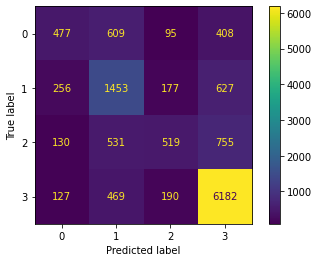

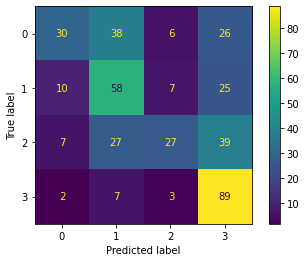

In [ ]:
# Confusion matrix whose i-th row and j-th column entry indicates 
# the number of samples with 
# true label being i-th class, and 
# predicted label being j-th class.
a = confusion_matrix(sess_gt_list, sess_pred_list)
a_per = a / np.sum(a, axis=1, keepdims=True) * 100
cm_display = ConfusionMatrixDisplay(a, display_labels=range(4)).plot(values_format='d')
cm_display = ConfusionMatrixDisplay(a_per, display_labels=range(4)).plot(values_format='2.0f')

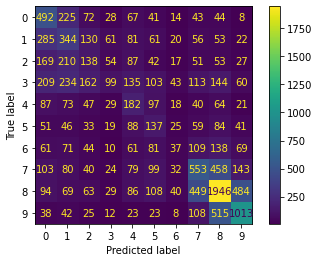

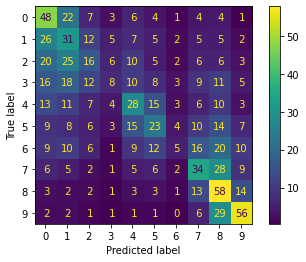

In [ ]:
a = confusion_matrix(pred_num_list, gt_num_list)
a_per = a / np.sum(a, axis=1, keepdims=True) * 100
cm_display = ConfusionMatrixDisplay(a, display_labels=range(10)).plot(values_format='d')
cm_display = ConfusionMatrixDisplay(a_per, display_labels=range(10)).plot(values_format='2.0f')

In [ ]:
s = 0
for i in range(10):
    s += a[i][i]
print(s)

4605


In [ ]:
4605 / np.sum(a)

0.35409457900807384

In [ ]:
np.sum(a)

13005

In [ ]:
a = one_zero + zero_one + one_one + zero_zero
print(one_zero)
print(zero_one)
print(one_one)
print(zero_zero) 
print('')
print(np.round(one_zero  / a, 2))
print(np.round(zero_one  / a, 2))
print(np.round(one_one   / a, 2))
print(np.round(zero_zero / a, 2)) 

[1842. 1766. 1681. 1399. 1459. 1411. 1192. 1327.  869.]
[ 489.  600.  778. 1235. 1222. 1231. 1344. 1203. 1334.]
[9831. 9651. 9357. 6867. 6842. 6742. 4269. 4093. 2000.]
[ 843.  988. 1189. 3504. 3482. 3621. 6200. 6382. 8802.]

[0.14 0.14 0.13 0.11 0.11 0.11 0.09 0.1  0.07]
[0.04 0.05 0.06 0.09 0.09 0.09 0.1  0.09 0.1 ]
[0.76 0.74 0.72 0.53 0.53 0.52 0.33 0.31 0.15]
[0.06 0.08 0.09 0.27 0.27 0.28 0.48 0.49 0.68]
